In [ ]:
# default_exp cls

# fullstream.cls

> Module containing the differentiable calculation of CLs values.

In [ ]:
#export
import jax
from jax import config
import pyhf

# avoid those precision errors!
config.update("jax_enable_x64", True)

pyhf.set_backend(pyhf.tensor.jax_backend())

from fullstream.fit import get_solvers
from fullstream.models import nn_model_maker
from fullstream.transforms import *

In [ ]:
#export
def cls_jax(nn_params, test_mu, transforms=False):

    g_fitter, c_fitter = get_solvers(nn_model_maker, transforms)

    m, bonlypars = nn_model_maker(nn_params)
    exp_data = m.expected_data(bonlypars)
    bounds = m.config.suggested_bounds()

    # map these
    initval = jax.numpy.asarray([test_mu, 1.])
    if transforms:
        initval = inv_transform_lim_vec(initval, bounds)
        init_test_mu = inv_transform_lim(test_mu, bounds[0])

        
    # the constrained fit
    numerator = transform_lim_vec(c_fitter(initval, [init_test_mu, nn_params]), bounds) if transforms else c_fitter(initval, [test_mu, nn_params])

    denominator = transform_lim_vec(g_fitter(initval, [init_test_mu, nn_params]), bounds) if transforms else g_fitter(initval, [test_mu, nn_params])

    print(f"constrained fit: {numerator}")
    print(f"global fit: {denominator}")

    # compute test statistic (lambda(µ))
    profile_likelihood = -2 * (
        m.logpdf(numerator, exp_data)[0] - m.logpdf(denominator, exp_data)[0]
    )

    # in exclusion fit zero out test stat if best fit µ^ is larger than test µ
    muhat = denominator[0]
    sqrtqmu = jax.numpy.sqrt(jax.numpy.where(muhat < test_mu, profile_likelihood, 0.0))
    #print(f"sqrt(q(mu)): {sqrtqmu}")
    # compute CLs
    nullval = sqrtqmu
    altval = 0
    CLsb = 1 - pyhf.tensorlib.normal_cdf(nullval)
    CLb = 1 - pyhf.tensorlib.normal_cdf(altval)
    CLs = CLsb / CLb
    return CLs


Starting training...
Epoch 0 in 2.63 sec
Training set accuracy 0.8476


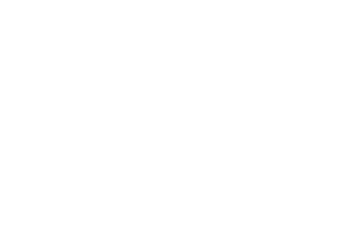

In [ ]:
from fullstream.nn import three_blob_classifier

x = three_blob_classifier()
_ = x.train(num_epochs=1)
nn_params = x.params

In [ ]:
cls_jax(nn_params, 1.0)

model: [ 6.40477037 13.59522963],[43.13707402  6.86292598],[4.44113382 4.44113382]
model: Traced<ShapedArray(float64[2]):JaxprTrace(level=0/0)>,Traced<ShapedArray(float64[2]):JaxprTrace(level=0/0)>,Traced<ShapedArray(float64[2]):JaxprTrace(level=0/0)>
model: Traced<ShapedArray(float64[2]):JaxprTrace(level=0/0)>,Traced<ShapedArray(float64[2]):JaxprTrace(level=0/0)>,Traced<ShapedArray(float64[2]):JaxprTrace(level=0/0)>
constrained fit: [1.         0.96071416]
global fit: [0.01694888 1.0021199 ]


DeviceArray(0.42813986, dtype=float64)

In [ ]:
cls_jax(nn_params, 1.0, True)

model: [ 6.40477037 13.59522963],[43.13707402  6.86292598],[4.44113382 4.44113382]
model: Traced<ShapedArray(float64[2]):JaxprTrace(level=0/0)>,Traced<ShapedArray(float64[2]):JaxprTrace(level=0/0)>,Traced<ShapedArray(float64[2]):JaxprTrace(level=0/0)>
model: Traced<ShapedArray(float64[2]):JaxprTrace(level=0/0)>,Traced<ShapedArray(float64[2]):JaxprTrace(level=0/0)>,Traced<ShapedArray(float64[2]):JaxprTrace(level=0/0)>
constrained fit: [ 1. 10.]
global fit: [0.         0.59398947]


DeviceArray(0., dtype=float64)